This script serves as a sanity check on the representation level.
The different data representations are used to classify call types as a proof of sufficient information.

DFA (PAFs), simple MLPs (LFCCs) and CNNs (spectrograms) are used to classify the different call types.

In [315]:
import pandas as pd
import numpy as np
import json
import random
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import resample
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, roc_auc_score
from sklearn.preprocessing import LabelBinarizer

In [316]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.RandomState(RANDOM_SEED)

RandomState(MT19937) at 0x1F981E440

### Create internal functions

In [317]:
def plot_confusion_matrix(true_labels, predicted_labels, class_names):    
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [318]:
# def _compute_roc_curve(val_targets, val_probs, num_classes):
#     val_targets = np.array(val_targets)
#     val_probs = np.array(val_probs)

#     all_labels_binarized = label_binarize(val_targets, classes=np.arange(num_classes))
#     fpr = {}
#     tpr = {}
#     roc_auc = {}

#     # For each class, compute the ROC curve and AUC
#     for i in range(num_classes):
#         fpr[i], tpr[i], _ = roc_curve(all_labels_binarized[:, i], val_probs[:, i])
#         roc_auc[i] = auc(fpr[i], tpr[i])

#     # Micro-average ROC curve
#     fpr["micro"], tpr["micro"], _ = roc_curve(all_labels_binarized.ravel(), val_probs.ravel())
#     roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

#     # Macro-average ROC curve
#     all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
#     mean_tpr = np.zeros_like(all_fpr)
#     for i in range(num_classes):
#         mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
#     mean_tpr /= num_classes

#     fpr["macro"] = all_fpr
#     tpr["macro"] = mean_tpr
#     roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

#     print(fpr["micro"].shape, tpr["micro"].shape, fpr["macro"].shape, tpr["macro"].shape, roc_auc["micro"], roc_auc["macro"])

#     return fpr, tpr, roc_auc

In [319]:
# def plot_roc_curve(true_labels, all_probs, num_classes, class_names):
#     fpr, tpr, roc_auc = _compute_roc_curve(true_labels, all_probs, num_classes)

#     # Plot ROC curve for each class
#     plt.figure(figsize=(10, 8))
#     for i in range(num_classes):
#         plt.plot(fpr[i], tpr[i], label = f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

#     # Plot micro-average and macro-average ROC curves
#     plt.plot(fpr["micro"], tpr["micro"], label=f"Micro-average (AUC = {roc_auc['micro']:.2f})", linestyle='--', color="blue")
#     plt.plot(fpr["macro"], tpr["macro"], label=f"Macro-average (AUC = {roc_auc['macro']:.2f})", linestyle='-.', color="navy")
    
#     # Plot the diagonal (random guess)
#     plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
    
#     # Configure the plot
#     plt.title("ROC Curve")
#     plt.xlabel("False Positive Rate")
#     plt.ylabel("True Positive Rate")
#     plt.legend(loc="lower right")
#     plt.grid()
#     plt.show()

In [320]:
def train_model(model, n_epochs, train_dl, device, optimizer, loss_criterion):
    # Train model
    model.train()
    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_dl:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = loss_criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {running_loss / len(train_dl):.4f}")

In [321]:
# def plot_roc_curve_with_ci(all_fpr_micro, all_tpr_micro, all_fpr_macro, all_tpr_macro, alpha=0.95):
#     print(len(all_fpr_micro[0], all_fpr_micro[1]))
#     all_fpr_micro = np.asarray(all_fpr_micro)
#     all_tpr_micro = np.asarray(all_tpr_micro)
#     all_fpr_macro = np.asarray(all_fpr_macro)
#     all_tpr_macro = np.asarray(all_tpr_macro)

#     # Calculate mean and confidence intervals for micro-average
#     mean_fpr_micro = np.mean(all_fpr_micro, axis=0)
#     mean_tpr_micro = np.mean(all_tpr_micro, axis=0)
#     tpr_micro_lower = np.percentile(all_tpr_micro, (1 - alpha) / 2 * 100, axis=0)
#     tpr_micro_upper = np.percentile(all_tpr_micro, (1 + alpha) / 2 * 100, axis=0)

#     # Calculate mean and confidence intervals for macro-average
#     mean_fpr_macro = np.mean(all_fpr_macro, axis=0)
#     mean_tpr_macro = np.mean(all_tpr_macro, axis=0)
#     tpr_macro_lower = np.percentile(all_tpr_macro, (1 - alpha) / 2 * 100, axis=0)
#     tpr_macro_upper = np.percentile(all_tpr_macro, (1 + alpha) / 2 * 100, axis=0)

#     # Plot ROC curve with confidence intervals
#     plt.figure(figsize=(10, 8))

#     # micro-average
#     plt.plot(mean_fpr_micro, mean_tpr_micro, label=f"Micro-average (AUC = {auc(mean_fpr_micro, mean_tpr_micro):.2f})", linestyle='--', color="blue")
#     plt.fill_between(mean_fpr_micro, tpr_micro_lower, tpr_micro_upper, color='blue', alpha=0.2)

#     # macro-average
#     plt.plot(mean_fpr_macro, mean_tpr_macro, label=f"Macro-average (AUC = {auc(mean_fpr_macro, mean_tpr_macro):.2f})", linestyle='-.', color="navy")
#     plt.fill_between(mean_fpr_macro, tpr_macro_lower, tpr_macro_upper, color='navy', alpha=0.2)

#     plt.plot([0, 1], [0, 1], color="gray", linestyle="--")

#     plt.title("ROC Curve")
#     plt.xlabel("False Positive Rate")
#     plt.ylabel("True Positive Rate")
#     plt.legend(loc="lower right")
#     plt.grid()
#     plt.show()

In [322]:
def test_model(model, test_dl, device):
    true_labels = []
    predicted_labels = []
    all_probs = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_dl:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)  # Convert logits to probabilities
            
            _, predicted = torch.max(outputs, 1)
            
            true_labels.append(labels.cpu().numpy())
            predicted_labels.append(predicted.cpu().numpy())
            all_probs.append(probs.cpu().numpy())
    
    true_labels = np.concatenate(true_labels, axis=0)
    predicted_labels = np.concatenate(predicted_labels, axis=0)
    all_probs = np.concatenate(all_probs, axis=0)
    
    return true_labels, predicted_labels, all_probs

In [323]:
def create_evaluation_plots(true_labels, predicted_labels, label_encoder, all_probs=None, num_classes=None):
    y_test_labels = label_encoder.inverse_transform(true_labels)
    y_pred_labels = label_encoder.inverse_transform(predicted_labels)
    print(classification_report(y_test_labels, y_pred_labels))
    plot_confusion_matrix(y_test_labels, y_pred_labels, label_encoder.classes_)
    if all_probs is None:
        return
    assert not num_classes is None
    #plot_roc_curve(true_labels, all_probs, num_classes, label_encoder.classes_)
    
def evaluate_model(model, test_dl, device, label_encoder, num_classes):
    true_labels, predicted_labels, all_probs = test_model(model, test_dl, device)
    create_evaluation_plots(true_labels, predicted_labels, label_encoder, all_probs, num_classes)

In [324]:
# https://scikit-learn.org/1.5/auto_examples/model_selection/plot_roc_crossval.html accessed January 14th, 19:04pm
# https://scikit-learn.org/1.5/auto_examples/model_selection/plot_roc.html accessed January 14th, 20:17pm
def cross_validate(dataset, model_class, device, batch_size, learning_rate, n_splits=5, n_epochs=10, n_classes=6, **model_kwargs):
    # TODO string class names
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
    fold_results = []

    tprs_per_class = {class_idx: [] for class_idx in range(n_classes)}
    mean_fpr = np.linspace(0, 1, 1000)
    micro_tprs = []
    macro_tprs = []

    # per class and averaging strategy
    fpr, tpr, roc_auc = dict(), dict(), dict()

    for fold, (train_idx, val_idx) in enumerate(cv.split(dataset, [y for _, y in dataset])):
        print(f"\n--- Fold {fold + 1} ---")
        model = model_class(num_classes=n_classes, **model_kwargs).to(device)
        
        # Create data loaders for current fold
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)
        train_dl = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_dl = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
        
        # Instantiate model, loss, optimizer
        model.to(device)
        loss_criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        
        train_model(model, n_epochs, train_dl, device, optimizer, loss_criterion)

        val_targets, val_predictions, val_probs = test_model(model, val_dl, device)
        label_binarizer = LabelBinarizer().fit([y for _, y in dataset])
        y_onehot_test = label_binarizer.transform(val_targets)
        val_probs = np.array(val_probs)

        # Compute validation accuracy
        fold_accuracy = accuracy_score(val_targets, val_predictions)
        print(f"Validation Accuracy for Fold {fold + 1}: {fold_accuracy:.4f}")
        fold_results.append(fold_accuracy)

        #-------------End of training---------       

        # Per class ROC curve
        for class_idx in range(n_classes):
            fpr[class_idx], tpr[class_idx], _ = roc_curve(y_onehot_test[:, class_idx], val_probs[:, class_idx])
            roc_auc[class_idx] = auc(fpr[class_idx], tpr[class_idx])
        
            # Interpolate TPR values on the fixed FPR grid
            interp_tpr = np.interp(mean_fpr, fpr[class_idx], tpr[class_idx])
            interp_tpr[0] = 0.0  # Ensure TPR starts at 0
            tprs_per_class[class_idx].append(interp_tpr)
            
        # Compute micro-average ROC curve and ROC area
        # store the fpr, tpr, and roc_auc for all averaging strategies
        fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), val_probs.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        # Interpolate TPR values on the fixed FPR grid
        interp_tpr = np.interp(mean_fpr, fpr["micro"], tpr["micro"])
        interp_tpr[0] = 0.0  # Ensure TPR starts at 0
        micro_tprs.append(interp_tpr)
        
        print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

        # Compute macro-average ROC curve and ROC area
        tprs_for_macro = []
        for class_idx in range(n_classes):
            fpr[class_idx], tpr[class_idx], _ = roc_curve(y_onehot_test[:, class_idx], val_probs[:, class_idx])
            roc_auc[class_idx] = auc(fpr[class_idx], tpr[class_idx])

            # Interpolate TPR values on the fixed FPR grid
            interp_tpr = np.interp(mean_fpr, fpr[class_idx], tpr[class_idx])
            interp_tpr[0] = 0.0  # Ensure TPR starts at 0
            tprs_for_macro.append(interp_tpr)

        # Compute the macro-average TPR for this fold
        macro_tpr = np.mean(tprs_for_macro, axis=0)
        macro_tpr[-1] = 1.0  # Ensure TPR ends at 1
        macro_tprs.append(macro_tpr)

    #-------------End of fold--------------

    # Final cross-validation results
    print("\nCross-Validation Results:")
    for i, acc in enumerate(fold_results):
        print(f"Fold {i + 1}: {acc:.4f}")
    print(f"Average Accuracy: {sum(fold_results) / len(fold_results):.4f}")

    # Compute mean and std for micro-average TPRs
    mean_micro_tpr = np.mean(micro_tprs, axis=0)
    std_micro_tpr = np.std(micro_tprs, axis=0)
    micro_tprs_upper = np.minimum(mean_micro_tpr + std_micro_tpr, 1)
    micro_tprs_lower = np.maximum(mean_micro_tpr - std_micro_tpr, 0)

    # Compute mean and std for macro-average TPRs
    mean_macro_tpr = np.mean(macro_tprs, axis=0)
    std_macro_tpr = np.std(macro_tprs, axis=0)
    macro_tprs_upper = np.minimum(mean_macro_tpr + std_macro_tpr, 1)
    macro_tprs_lower = np.maximum(mean_macro_tpr - std_macro_tpr, 0)

    #--------------Plots----------------
    fig, ax = plt.subplots(figsize=(9, 9))
    # Plot micro-average ROC curve with CI
    ax.plot(
        mean_fpr,
        mean_micro_tpr,
        label=f"Micro-average ROC curve ± 1 std. dev.(AUC = {roc_auc['micro']:.2f})",
        color="deeppink",
        linestyle="--",
        linewidth=1.5,
    )
    ax.fill_between(
        mean_fpr,
        micro_tprs_lower,
        micro_tprs_upper,
        color="pink",
        alpha=0.2,
    )

    # Plot macro-average ROC curve with CI
    ax.plot(
        mean_fpr,
        mean_macro_tpr,
        label=f"Macro-average ROC curve ± 1 std. dev.(AUC = {np.mean([auc(fpr[class_idx], tpr[class_idx]) for class_idx in range(n_classes)]):.2f})",
        color="navy",
        linestyle="--",
        linewidth=1.5,
    )
    ax.fill_between(
        mean_fpr,
        macro_tprs_lower,
        macro_tprs_upper,
        color="blue",
        alpha=0.2,
    )

    # Plot average curve per class
    for class_idx in range(n_classes):
        mean_tpr = np.mean(tprs_per_class[class_idx], axis=0)
        std_tpr = np.std(tprs_per_class[class_idx], axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

        # Plot mean ROC curve with AUC
        ax.plot(mean_fpr, mean_tpr, label=f"Class {class_idx} ± 1 std. dev. (AUC = {roc_auc[class_idx]:.2f})")
        ax.fill_between(mean_fpr, tprs_lower, tprs_upper, alpha=0.2)

    # Plot random
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--", alpha=0.5)

    _ = ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title="ROC One-vs-Rest multiclass",
    )
    
    ax.legend(loc="lower right")
    plt.show()

In [325]:
def bootstrap_model(dataset, model_class, device, batch_size, learning_rate, num_bootstrap_samples=10, n_epochs=10, **model_kwargs):
    bootstrap_results = []

    for i in range(num_bootstrap_samples):
        print(f"\n--- Bootstrap Sample {i + 1} ---")
        
        # Generate bootstrap sample (with replacement)
        indices = resample(range(len(dataset)), replace=True, n_samples=len(dataset), random_state=i)
        oob_indices = list(set(range(len(dataset))) - set(indices))  # Out-of-Bag (OOB) indices

        train_subset = Subset(dataset, indices)
        oob_subset = Subset(dataset, oob_indices)
        train_dl = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        oob_dl = DataLoader(oob_subset, batch_size=batch_size, shuffle=False)
        
        # Instantiate model, loss, and optimizer
        model = model_class(**model_kwargs).to(device)
        loss_criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        
        train_model(model, n_epochs, train_dl, device, optimizer, loss_criterion)
        oob_targets, oob_predictions, _ = test_model(model, oob_dl, device)

        # Compute OOB accuracy
        if oob_targets: 
            oob_accuracy = accuracy_score(oob_targets, oob_predictions)
            print(f"OOB Accuracy for Bootstrap Sample {i + 1}: {oob_accuracy:.4f}")
            bootstrap_results.append(oob_accuracy)
        else:
            print("No OOB samples for this bootstrap iteration.")
            bootstrap_results.append(None)

    # Final bootstrap results
    print("\nBootstrap Results:")
    for i, acc in enumerate(bootstrap_results):
        print(f"Bootstrap Sample {i + 1}: {acc if acc is not None else 'N/A'}")
    valid_accuracies = [acc for acc in bootstrap_results if acc is not None]
    if valid_accuracies:
        print(f"Average OOB Accuracy: {sum(valid_accuracies) / len(valid_accuracies):.4f}")
    else:
        print("No valid OOB accuracy to average.")


### Load data

In [326]:
calls_df = pd.read_csv('features_and_spectrograms.csv')
calls_df['log_padded_spectrogram'] = calls_df['log_padded_spectrogram'].apply(lambda x: np.array(json.loads(x)))
calls_df['log_padded_lfccs'] = calls_df['log_padded_lfccs'].apply(lambda x: np.asarray(json.loads(x)))

In [327]:
print(len(calls_df[calls_df.isna().any(axis=1)]))
calls_df = calls_df.dropna()
calls_df = calls_df[calls_df['call_type'] != 'unknown']
calls_df.info()

811
<class 'pandas.core.frame.DataFrame'>
Index: 6323 entries, 0 to 7282
Data columns (total 35 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   track_ID                6323 non-null   object 
 1   clip_ID                 6323 non-null   object 
 2   goose_ID                6323 non-null   object 
 3   call_type               6323 non-null   object 
 4   waveform                6323 non-null   object 
 5   sr                      6323 non-null   int64  
 6   filepath                6323 non-null   object 
 7   lfccs                   6323 non-null   object 
 8   peak                    6323 non-null   float64
 9   duration                6323 non-null   float64
 10  log_padded_spectrogram  6323 non-null   object 
 11  log_padded_lfccs        6323 non-null   object 
 12  f0mean                  6323 non-null   float64
 13  f0range                 6323 non-null   float64
 14  f0min                   6323 non-null   f

In [328]:
le = LabelEncoder()
y = le.fit_transform(calls_df["call_type"])

## DFA

In [329]:
features_list = ["duration", "f0mean", "f0range", "f0min", "f0max", "f0std_dev", "mean_slope", "f0_q1", "f0_q2", "f0_q3", "hnr", "centr_s", "skew_s", "kurt_s", "std_s", "centr_t", "skew_t", "kurt_t", "std_t", "avg_f_form1"]

In [330]:
X = calls_df[features_list].values
X_scaled = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=RANDOM_SEED)

In [331]:
qda = QDA(reg_param=0.2)
qda.fit(X_train, y_train)

/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis(reg_param=0.2)

              precision    recall  f1-score   support

       alarm       0.00      0.00      0.00        14
     contact       0.46      0.21      0.28       228
   departure       0.77      0.83      0.80       214
    distance       0.92      0.91      0.91        98
 recruitment       0.72      0.87      0.79       651
     triumph       0.26      0.12      0.16        60

    accuracy                           0.70      1265
   macro avg       0.52      0.49      0.49      1265
weighted avg       0.66      0.70      0.67      1265



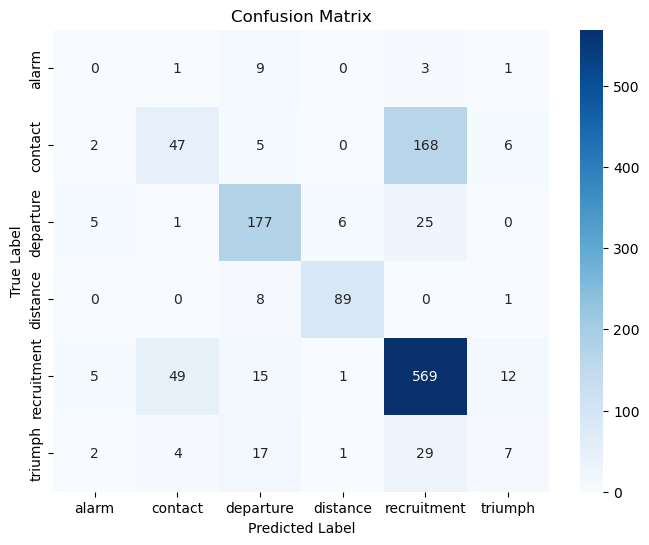

In [332]:
y_pred = qda.predict(X_test)
create_evaluation_plots(y_test, y_pred, le)

In [333]:
lda = LDA(solver="lsqr", shrinkage=0, n_components=1)
lda.fit(X_train, y_train)

LinearDiscriminantAnalysis(n_components=1, shrinkage=0, solver='lsqr')

              precision    recall  f1-score   support

       alarm       0.05      0.07      0.06        14
     contact       0.59      0.07      0.13       228
   departure       0.84      0.79      0.82       214
    distance       0.97      0.91      0.94        98
 recruitment       0.70      0.95      0.81       651
     triumph       0.31      0.22      0.25        60

    accuracy                           0.72      1265
   macro avg       0.58      0.50      0.50      1265
weighted avg       0.70      0.72      0.66      1265



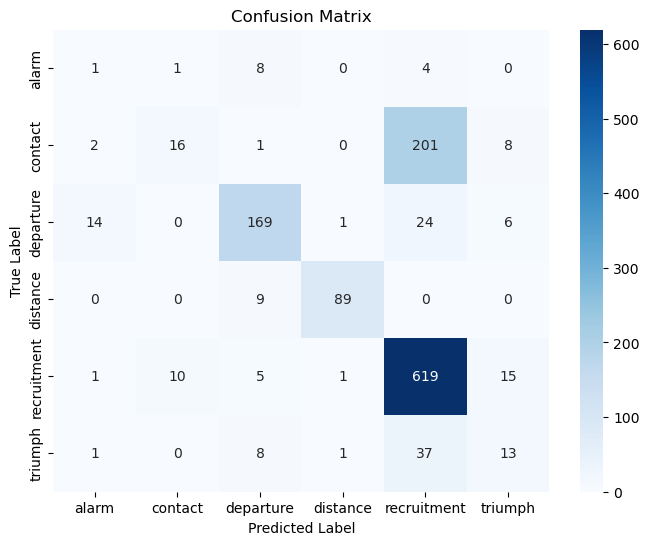

Feature coefficients per class:
   duration    f0mean   f0range     f0min     f0max  f0std_dev  mean_slope  \
0 -1.287448  9.308294  0.680101 -1.167731 -0.325774  -0.992151   -0.453475   
1 -0.888282  0.446316 -0.995798  0.216377 -0.623857   0.972619    0.351613   
2  1.502519 -1.138024  2.067075 -0.830374  1.013987  -2.066850   -0.682432   
3  3.836731 -5.979485  1.934937  0.949214  2.221850  -2.357568   -0.857550   
4 -0.826284  0.533443 -0.565152  0.096017 -0.373806   0.629376    0.256940   
5  1.871788  0.312526 -0.238976  0.295803  0.030056   0.480142   -0.221894   

      f0_q1     f0_q2     f0_q3       hnr   centr_s    skew_s    kurt_s  \
0 -3.773035 -3.193956 -0.589638  0.037982  1.524500  0.840236 -0.230266   
1  0.047616  0.031438 -0.748836 -0.097371 -0.473969 -0.178479 -0.002370   
2 -0.031959  0.466762  1.532256  0.300912  1.279067  0.593614 -0.221151   
3  1.245161 -1.049848  4.259138  1.028817 -0.157671  0.771593 -0.247226   
4 -0.068429  0.148065 -0.727214 -0.144557 -0.2

In [334]:
y_pred = lda.predict(X_test)
create_evaluation_plots(y_test, y_pred, le)
coef_df = pd.DataFrame(lda.coef_, columns=features_list, index=lda.classes_)
print("Feature coefficients per class:")
print(coef_df)

In [335]:
param_grid = {
    'solver': ['svd', 'lsqr', 'eigen'],
    'shrinkage': ['auto', 0.0, 0.1, 0.5, 1.0],
    'n_components': [1, 2, 3]
}

# GridSearchCV for LDA
grid_search = GridSearchCV(LDA(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Evaluate on the test set
best_lda = grid_search.best_estimator_
y_pred = best_lda.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Best Parameters: {'n_components': 1, 'shrinkage': 0.0, 'solver': 'lsqr'}
Best Cross-Validation Accuracy: 0.6789241270921055
Test Accuracy: 0.71699604743083


/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
78 fits failed out of a total of 225.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File 

In [336]:
param_grid = {'reg_param': [0.0, 0.1, 0.2, 0.5, 1.0]}

# GridSearchCV for QDA
grid_search = GridSearchCV(QDA(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Evaluate on the test set
best_qda = grid_search.best_estimator_
y_pred = best_qda.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Best Parameters: {'reg_param': 0.2}
Best Cross-Validation Accuracy: 0.67832909145643
Test Accuracy: 0.7027667984189724


/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/len

In [337]:
abs_coef = coef_df.abs().mean(axis=0)
print("Feature Importance Ranking:")
print(abs_coef.sort_values(ascending=False))

Feature Importance Ranking:
centr_t        4.366481
f0mean         2.953014
duration       1.702176
f0_q3          1.386038
f0std_dev      1.249784
f0range        1.080340
f0_q1          0.870566
f0_q2          0.844301
f0max          0.764888
std_s          0.714070
kurt_t         0.699711
skew_t         0.676554
centr_s        0.657893
skew_s         0.630122
f0min          0.592586
avg_f_form1    0.552402
mean_slope     0.470651
std_t          0.380654
hnr            0.334767
kurt_s         0.177408
dtype: float64


In [338]:
# simulate chance level
true_labels = calls_df["call_type"]
class_probs = true_labels.value_counts(normalize=True)
random_predictions = np.random.choice(class_probs.index, size=len(true_labels), p=class_probs.values)

# Calculate accuracy for random guessing
random_accuracy = accuracy_score(true_labels, random_predictions)

print("Empirical Chance Level (Random Guessing):", random_accuracy)


Empirical Chance Level (Random Guessing): 0.3038114818915072


In [339]:
# Permutation test to evaluate the significance of LDA model's accuracy
def permutation_test(X, y, model, num_permutations=20, test_size=0.2, random_state=RANDOM_SEED):

    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Train LDA and calculate the accuracy
    model.fit(X_train, y_train)
    real_accuracy = accuracy_score(y_test, model.predict(X_test))

    # List to store accuracies from shuffled labels
    permuted_accuracies = []

    # Perform permutation test
    for _ in range(num_permutations):
        # Shuffle labels
        shuffled_y = np.random.permutation(y)

        # Train LDA on shuffled labels
        model.fit(X_train, shuffled_y[:len(y_train)])
        permuted_accuracy = accuracy_score(y_test, model.predict(X_test))

        # Append permuted accuracy to list
        permuted_accuracies.append(permuted_accuracy)

    # Calculate p-value
    permuted_accuracies = np.array(permuted_accuracies)
    p_value = np.mean(permuted_accuracies >= real_accuracy)


    # Plot histogram of permuted accuracies
    plt.hist(permuted_accuracies, alpha=0.7, color='blue', label='Permuted Accuracies')

    plt.axvline(real_accuracy, color='red', linestyle='dashed', linewidth=1, label='Real Accuracy')

    plt.title(f"Permutation Test for {str(model)}")
    plt.xlabel("Accuracy")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

    print("Real Accuracy:", real_accuracy)
    print("P-value:", "{:.8f}".format(p_value))

    return real_accuracy, permuted_accuracies, p_value

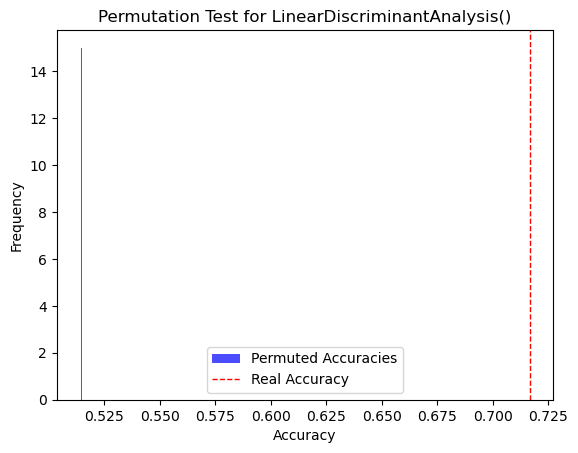

Real Accuracy: 0.71699604743083
P-value: 0.00000000


/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/len

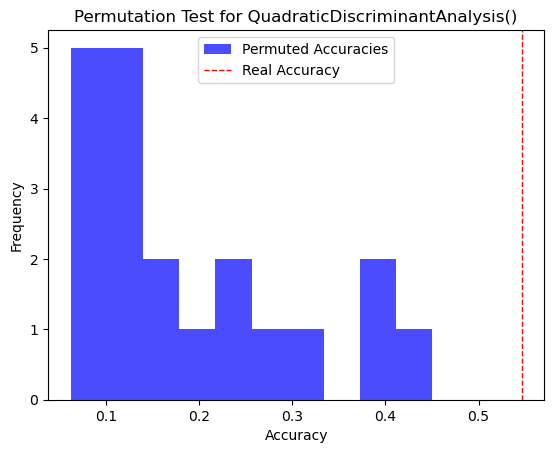

Real Accuracy: 0.5462450592885375
P-value: 0.00000000


In [340]:
real_accuracy, permuted_accuracies, p_value = permutation_test(X_scaled, y, LDA())
real_accuracy, permuted_accuracies, p_value = permutation_test(X_scaled, y, QDA())


## MLP

## CNN

#### LFCCs

In [341]:
LEARNING_RATE = 1e-3
BATCH_SIZE = 256
N_EPOCHS = 5

In [342]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [343]:
le = LabelEncoder()
le.fit(calls_df["call_type"])
calls_df["encoded_call_type"] = le.transform(calls_df["call_type"])

In [344]:
lfccs_flat = np.array([x.flatten() for x in calls_df['log_padded_lfccs']]) 

scaler = StandardScaler()
lfccs_scaled = scaler.fit_transform(lfccs_flat)

# Reshape to original dimensions
n_samples, height, width = len(calls_df), calls_df['log_padded_lfccs'][0].shape[0], calls_df['log_padded_lfccs'][0].shape[1]
lfccs_scaled = lfccs_scaled.reshape(n_samples, height, width)  

# Assign the scaled features back to the DataFrame if needed
calls_df['log_padded_lfccs_scaled'] = list(lfccs_scaled)

In [345]:
class LFCCDataset(Dataset):
    def __init__(self, df):
        self.df = calls_df
        self.features = np.array(df['log_padded_lfccs_scaled'].tolist(), dtype=np.float32)  # Shape: (n_samples, 16, 215)
        self.labels = np.array(df['encoded_call_type'], dtype=np.int64)  # Shape: (n_samples,)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = torch.from_numpy(self.df.iloc[idx]["log_padded_lfccs_scaled"]).to(torch.float32).to(device)
        x = x[np.newaxis, ...] # Add channel dimension -> Shape: (1, 16, 215)
        return x, self.df.iloc[idx]["encoded_call_type"]

ds_lfcc = LFCCDataset(calls_df)

num_items = len(ds_lfcc)
num_train = round(num_items * 0.8)
num_val = round(num_items * 0.1)
num_test = num_items - num_train - num_val
train_ds, val_ds, test_ds = random_split(ds_lfcc, [num_train, num_val, num_test])

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

In [346]:
train_features, train_labels = next(iter(train_dl))
print(f"Feature batch shape: {train_features.size()}")

input_size=train_features.size()[1:]
print(input_size[1], input_size[2])

Feature batch shape: torch.Size([256, 1, 16, 215])
16 215


In [347]:
class LFCCCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        self.layers = torch.nn.Sequential( # (1, 16, 215)
            nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1), # (32, 16, 215)
            nn.MaxPool2d(kernel_size=(2, 2)), # (32, 8, 107)
            nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1), # (64, 8, 107)
            nn.Flatten(),
            nn.Linear(64 * 8 * 107, 128),  # flattened size: 64 * (16/2) * (215/2)
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.layers(x)
        return x

In [348]:
# Instantiate model
n_classes = 6
model = LFCCCNN(n_classes)

# Loss and Optimizer
loss_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
model.to(device)

# Train
n_epochs = N_EPOCHS
train_model(model, n_epochs, train_dl, device, optimizer, loss_criterion)

# Evaluate
val_targets, val_predictions, _ = test_model(model, val_dl, device)
print(f"Validation Accuracy: {accuracy_score(val_targets, val_predictions):.4f}")

Epoch 1/5, Loss: 2.1530
Epoch 2/5, Loss: 0.6513
Epoch 3/5, Loss: 0.4441
Epoch 4/5, Loss: 0.3922
Epoch 5/5, Loss: 0.3670
Validation Accuracy: 0.7816


              precision    recall  f1-score   support

       alarm       0.30      0.50      0.38         6
     contact       0.55      0.64      0.59       131
   departure       0.99      0.90      0.94       103
    distance       0.90      0.96      0.93        47
 recruitment       0.84      0.80      0.82       310
     triumph       0.66      0.53      0.58        36

    accuracy                           0.78       633
   macro avg       0.71      0.72      0.71       633
weighted avg       0.79      0.78      0.78       633



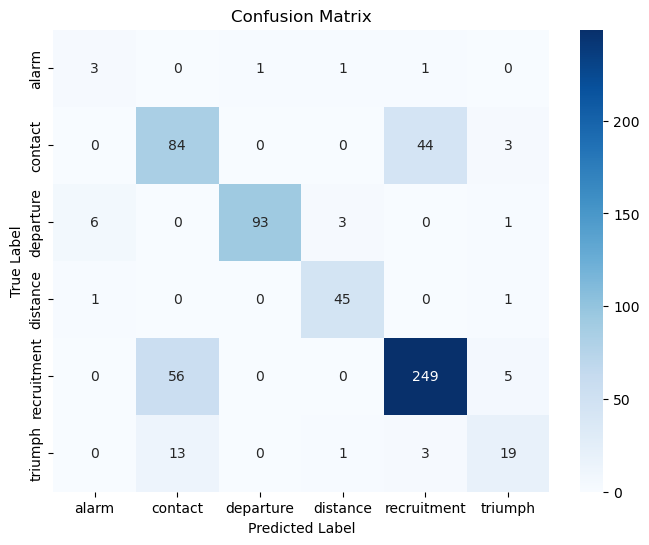

In [349]:
evaluate_model(model, test_dl, device, le, num_classes=6)

#### Spectrograms

In [350]:
specs_flat = np.array([x.flatten() for x in calls_df['log_padded_spectrogram']]) 

scaler = StandardScaler()
specs_scaled = scaler.fit_transform(specs_flat)

# Reshape to original dimensions
n_samples, height, width = len(calls_df), calls_df['log_padded_spectrogram'][0].shape[0], calls_df['log_padded_spectrogram'][0].shape[1]
specs_scaled = specs_scaled.reshape(n_samples, height, width)  

# Assign the scaled features back to the DataFrame if needed
calls_df['log_padded_spectrogram_scaled'] = list(specs_scaled)

In [351]:
class SpecDataset(Dataset):
    def __init__(self, df):
        self.df = calls_df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        x = torch.from_numpy(self.df.iloc[idx]["log_padded_spectrogram_scaled"]).to(torch.float32).to(device) # Shape: (n_samples, 16, 215)
        x = x[np.newaxis, ...] # Add channel dimension -> Shape: (1, 16, 215)
        return x, self.df.iloc[idx]["encoded_call_type"]

ds_spec = SpecDataset(calls_df)

num_items = len(ds_spec)
num_train = round(num_items * 0.7)
num_val = round(num_items * 0.15)
num_test = num_items - num_train - num_val
train_ds, val_ds, test_ds = random_split(ds_spec, [num_train, num_val, num_test])

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

In [352]:
train_features, train_labels = next(iter(train_dl))
print(f"Feature batch shape: {train_features.size()}")

input_size=train_features.size()[1:]
print(input_size[1], input_size[2])

Feature batch shape: torch.Size([256, 1, 44, 170])
44 170


In [353]:
class SpecCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        self.layers = torch.nn.Sequential( # (1, 44, 170)
            nn.Conv2d(1, 16, kernel_size=(3, 3), padding=1), # (16, 44, 170)
            nn.MaxPool2d(kernel_size=(2, 2)), # (16, 22, 85)
            nn.Conv2d(16, 32, kernel_size=(3, 3), padding=1), # (32, 22, 85)
            nn.Flatten(),
            nn.Linear(32 * 22 * 85, 128),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.layers(x)
        return x

In [354]:
# Instantiate model
n_classes = 6
model = SpecCNN(n_classes)

# Loss and Optimizer
loss_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
model.to(device)

# Train
n_epochs = N_EPOCHS
train_model(model, n_epochs, train_dl, device, optimizer, loss_criterion)

# Evaluate
val_targets, val_predictions, _ = test_model(model, val_dl, device)
print(f"Validation Accuracy: {accuracy_score(val_targets, val_predictions):.4f}")

Epoch 1/5, Loss: 2.6748
Epoch 2/5, Loss: 0.7052
Epoch 3/5, Loss: 0.4718
Epoch 4/5, Loss: 0.3479
Epoch 5/5, Loss: 0.3116
Validation Accuracy: 0.7764


              precision    recall  f1-score   support

       alarm       0.75      0.33      0.46         9
     contact       0.75      0.52      0.61       206
   departure       0.92      0.94      0.93       136
    distance       0.92      1.00      0.96        81
 recruitment       0.79      0.90      0.84       458
     triumph       0.63      0.58      0.60        59

    accuracy                           0.81       949
   macro avg       0.79      0.71      0.74       949
weighted avg       0.80      0.81      0.80       949



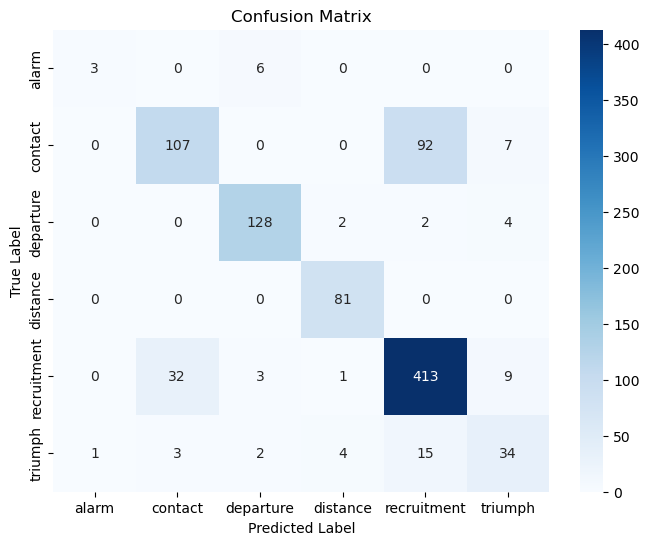

In [355]:
evaluate_model(model, test_dl, device, le, num_classes=6)


--- Fold 1 ---
Epoch 1/2, Loss: 2.7672
Epoch 2/2, Loss: 0.9379
Validation Accuracy for Fold 1: 0.7590
Micro-averaged One-vs-Rest ROC AUC score:
0.96

--- Fold 2 ---
Epoch 1/2, Loss: 4.0791
Epoch 2/2, Loss: 1.1975
Validation Accuracy for Fold 2: 0.6482
Micro-averaged One-vs-Rest ROC AUC score:
0.94

Cross-Validation Results:
Fold 1: 0.7590
Fold 2: 0.6482
Average Accuracy: 0.7036


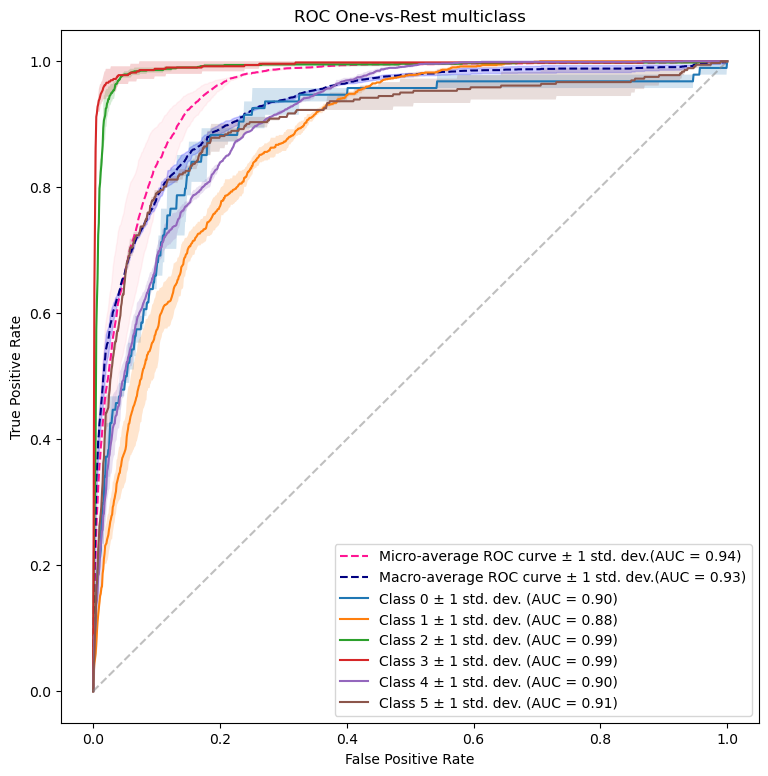

In [356]:
cross_validate(ds_spec, SpecCNN, device, batch_size=BATCH_SIZE, learning_rate=LEARNING_RATE, n_splits=2, n_epochs=2, n_classes=6)
#bootstrap_model(ds_spec, SpecCNN, device, batch_size=BATCH_SIZE, learning_rate=LEARNING_RATE, n_epochs=15, num_classes=6)


--- Fold 1 ---
Epoch 1/2, Loss: 1.9511
Epoch 2/2, Loss: 0.6240
Validation Accuracy for Fold 1: 0.7684
Micro-averaged One-vs-Rest ROC AUC score:
0.96

--- Fold 2 ---
Epoch 1/2, Loss: 1.5374
Epoch 2/2, Loss: 0.5656
Validation Accuracy for Fold 2: 0.7739
Micro-averaged One-vs-Rest ROC AUC score:
0.97

--- Fold 3 ---
Epoch 1/2, Loss: 2.4724
Epoch 2/2, Loss: 0.6712
Validation Accuracy for Fold 3: 0.7621
Micro-averaged One-vs-Rest ROC AUC score:
0.96

--- Fold 4 ---
Epoch 1/2, Loss: 1.8046
Epoch 2/2, Loss: 0.5842
Validation Accuracy for Fold 4: 0.7619
Micro-averaged One-vs-Rest ROC AUC score:
0.96

--- Fold 5 ---
Epoch 1/2, Loss: 1.9444
Epoch 2/2, Loss: 0.6440
Validation Accuracy for Fold 5: 0.7880
Micro-averaged One-vs-Rest ROC AUC score:
0.97

Cross-Validation Results:
Fold 1: 0.7684
Fold 2: 0.7739
Fold 3: 0.7621
Fold 4: 0.7619
Fold 5: 0.7880
Average Accuracy: 0.7708


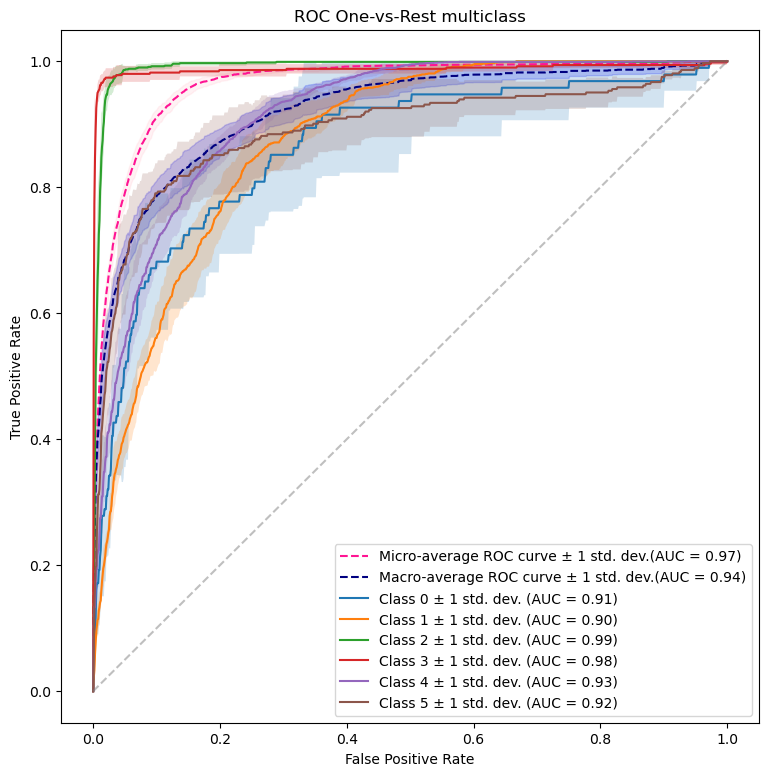

In [357]:
cross_validate(ds_lfcc, LFCCCNN, device, batch_size=BATCH_SIZE, learning_rate=LEARNING_RATE, n_epochs=2, n_classes=6)
#bootstrap_model(ds_lfcc, LFCCCNN, device, batch_size=BATCH_SIZE, learning_rate=LEARNING_RATE, n_epochs=20, num_classes=6)